## Aging Responder Analysis


## Notebook description
This notebook analyzes the Aging clincial trial study. 

The first step in this notebook is to transform the baseline algorithms data extract using the pre-defined criterion. This data transformation will help in preparing the data for responder analysis. Once the data is transformed and is ready to be analyzed, we perform the Responder analysis on the data extract using exactly the same input parameters from the feature identification analysis.

We then use range of statistical techniques like weekly treatment effect CI visualization, t-test, Mann Whitney test, binomial test, randomization test and effect size to understand the treatment effect in the Aging study.

## Input data

`AGING_DATA_EXTRACT__NEW_NQSD_20231214.csv`  
This dataset is the newer Aging data extract based on the baseline algorithms v4 labels

In [1]:
import sys, os
import scipy
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from decimal import Decimal
from matplotlib.pylab import plt
from catboost import CatBoostClassifier
from sklearn.preprocessing import MinMaxScaler

scripts_master = os.path.dirname('../../advanced_stats_code_library/src/')
sys.path.insert(0, scripts_master) 
from responder_analysis import responder_utils

from norm_excursion.report_results import ReportResults
from norm_excursion.norm_excursion import NormExcursion
from norm_excursion.study_meta_data import StudyMetaData
from norm_excursion.data_validation import DataValidation
from responder_analysis.responder_analysis import ResponderAnalysis
from statsmodels.stats.proportion import proportion_confint
from power_analysis.power_analysis import PowerAnalysis
from scipy import stats
power_analysis=PowerAnalysis()
import warnings
warnings.filterwarnings('ignore')
palette = sns.color_palette('deep', 10)
plt.style.use('seaborn-whitegrid')
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
params = {
            'legend.fontsize': 'x-large',
            'axes.labelsize': 'x-large',
            'axes.titlesize':'x-large',
            'xtick.labelsize':'x-large',
            'ytick.labelsize':'x-large'
        }
plt.rcParams.update(params)
pd.set_option('display.max_rows', 700)
pd.set_option('display.max_columns', 700)

## Reading the data extracts

In [2]:
data_nopop = pd.read_csv("gs://hpn_cte_advanced_stats_data_repository/yahui_data_repository/Aging 202312/AGING_DATA_EXTRACT__NEW_NQSD_20231214.csv")
population = pd.read_csv("gs://hpn_cte_advanced_stats_data_repository/yahui_data_repository/Aging 202312/population_updates_20231214.csv")

In [3]:
data = pd.merge(data_nopop, population, on=['PET_ID'], how='left')

In [4]:
data[(data['IS_QUALIFIED'] == 'YES') & (data['wearables_pp'] == True)]['PET_ID'].nunique()

42

In [5]:
data[(data['IS_QUALIFIED'] == 'YES') & (data['wearables_itt'] == True)]['PET_ID'].nunique()

135

In [6]:
data[(data['IS_QUALIFIED_NEW'] == 'YES') & (data['wearables_pp'] == True)]['PET_ID'].nunique()

42

In [7]:
data[(data['IS_QUALIFIED_NEW'] == 'YES') & (data['wearables_itt'] == True)]['PET_ID'].nunique()

135

In [8]:
data.head()

,PET_ID,EXTERNAL_ID,DEVICE_ID,STUDY_ID,STUDY_NAME,PET_NAME,DATE,NORMALIZED_STUDY_DAY,NORMALIZED_QUALIFYING_STUDY_DAY,STUDY_DAY_COUNTER,STUDY_GROUP,BASELINE_START,START_DATE,ENROLLMENT_DATE,COMPLETION_DATE,END_DATE,EXCESSIVE_RUNNING,TIMEZONE,QUALIFYING_DATA_DAY,IS_QUALIFIED,DAILYDATAQUALITYINDREASON,VAR_TD_1_Q1_2,VAR_CE_1_Q1_2,VAR_MIN_1_Q1_2,VAR_MED_1_Q1_2,VAR_RANG_1_Q1_2,VAR_MAX_1_Q1_2,VAR_AVG_1_Q1_2,VAR_SD_1_Q1_2,VAR_IQR_1_Q1_2,VAR_ACE_1_Q1_2,VAR_SDCE_1_Q1_2,VAR_IQRCE_1_Q1_2,VAR_CE3SD_1_Q1_2,VAR_TD_3_Q1_2,VAR_CE_3_Q1_2,VAR_MIN_3_Q1_2,VAR_MED_3_Q1_2,VAR_RANG_3_Q1_2,VAR_MAX_3_Q1_2,VAR_AVG_3_Q1_2,VAR_SD_3_Q1_2,VAR_IQR_3_Q1_2,VAR_ACE_3_Q1_2,VAR_SDCE_3_Q1_2,VAR_IQRCE_3_Q1_2,VAR_CE3SD_3_Q1_2,VAR_TD_5_Q1_2,VAR_CE_5_Q1_2,VAR_MIN_5_Q1_2,VAR_MED_5_Q1_2,VAR_RANG_5_Q1_2,VAR_MAX_5_Q1_2,VAR_AVG_5_Q1_2,VAR_SD_5_Q1_2,VAR_IQR_5_Q1_2,VAR_ACE_5_Q1_2,VAR_SDCE_5_Q1_2,VAR_IQRCE_5_Q1_2,VAR_CE3SD_5_Q1_2,VAR_TD_4_Q1_2,VAR_CE_4_Q1_2,VAR_MIN_4_Q1_2,VAR_MED_4_Q1_2,VAR_RANG_4_Q1_2,VAR_MAX_4_Q1_2,VAR_AVG_4_Q1_2,VAR_SD_4_Q1_2,VAR_IQR_4_Q1_2,VAR_ACE_4_Q1_2,VAR_SDCE_4_Q1_2,VAR_IQRCE_4_Q1_2,VAR_CE3SD_4_Q1_2,VAR_TD_12_Q1_2,VAR_CE_12_Q1_2,VAR_MIN_12_Q1_2,VAR_MED_12_Q1_2,VAR_RANG_12_Q1_2,VAR_MAX_12_Q1_2,VAR_AVG_12_Q1_2,VAR_SD_12_Q1_2,VAR_IQR_12_Q1_2,VAR_ACE_12_Q1_2,VAR_SDCE_12_Q1_2,VAR_IQRCE_12_Q1_2,VAR_CE3SD_12_Q1_2,VAR_TD_2_Q1_2,VAR_CE_2_Q1_2,VAR_MIN_2_Q1_2,VAR_MED_2_Q1_2,VAR_RANG_2_Q1_2,VAR_MAX_2_Q1_2,VAR_AVG_2_Q1_2,VAR_SD_2_Q1_2,VAR_IQR_2_Q1_2,VAR_ACE_2_Q1_2,VAR_SDCE_2_Q1_2,VAR_IQRCE_2_Q1_2,VAR_CE3SD_2_Q1_2,VAR_TD_46_Q1_2,VAR_CE_46_Q1_2,VAR_MIN_46_Q1_2,VAR_MED_46_Q1_2,VAR_RANG_46_Q1_2,VAR_MAX_46_Q1_2,VAR_AVG_46_Q1_2,VAR_SD_46_Q1_2,VAR_IQR_46_Q1_2,VAR_ACE_46_Q1_2,VAR_SDCE_46_Q1_2,VAR_IQRCE_46_Q1_2,VAR_CE3SD_46_Q1_2,VAR_TD_45_Q1_2,VAR_CE_45_Q1_2,VAR_MIN_45_Q1_2,VAR_MED_45_Q1_2,VAR_RANG_45_Q1_2,VAR_MAX_45_Q1_2,VAR_AVG_45_Q1_2,VAR_SD_45_Q1_2,VAR_IQR_45_Q1_2,VAR_ACE_45_Q1_2,VAR_SDCE_45_Q1_2,VAR_IQRCE_45_Q1_2,VAR_IDX_11_Q1_2,VAR_CE3SD_45_Q1_2,VAR_TD_1_Q2_2,VAR_CE_1_Q2_2,VAR_MIN_1_Q2_2,VAR_MED_1_Q2_2,VAR_RANG_1_Q2_2,VAR_MAX_1_Q2_2,VAR_AVG_1_Q2_2,VAR_SD_1_Q2_2,VAR_IQR_1_Q2_2,VAR_ACE_1_Q2_2,VAR_SDCE_1_Q2_2,VAR_IQRCE_1_Q2_2,VAR_CE3SD_1_Q2_2,VAR_TD_3_Q2_2,VAR_CE_3_Q2_2,VAR_MIN_3_Q2_2,VAR_MED_3_Q2_2,VAR_RANG_3_Q2_2,VAR_MAX_3_Q2_2,VAR_AVG_3_Q2_2,VAR_SD_3_Q2_2,VAR_IQR_3_Q2_2,VAR_ACE_3_Q2_2,VAR_SDCE_3_Q2_2,VAR_IQRCE_3_Q2_2,VAR_CE3SD_3_Q2_2,VAR_TD_5_Q2_2,VAR_CE_5_Q2_2,VAR_MIN_5_Q2_2,VAR_MED_5_Q2_2,VAR_RANG_5_Q2_2,VAR_MAX_5_Q2_2,VAR_AVG_5_Q2_2,VAR_SD_5_Q2_2,VAR_IQR_5_Q2_2,VAR_ACE_5_Q2_2,VAR_SDCE_5_Q2_2,VAR_IQRCE_5_Q2_2,VAR_CE3SD_5_Q2_2,VAR_TD_4_Q2_2,VAR_CE_4_Q2_2,VAR_MIN_4_Q2_2,VAR_MED_4_Q2_2,VAR_RANG_4_Q2_2,VAR_MAX_4_Q2_2,VAR_AVG_4_Q2_2,VAR_SD_4_Q2_2,VAR_IQR_4_Q2_2,VAR_ACE_4_Q2_2,VAR_SDCE_4_Q2_2,VAR_IQRCE_4_Q2_2,VAR_CE3SD_4_Q2_2,VAR_TD_12_Q2_2,VAR_CE_12_Q2_2,VAR_MIN_12_Q2_2,VAR_MED_12_Q2_2,VAR_RANG_12_Q2_2,VAR_MAX_12_Q2_2,VAR_AVG_12_Q2_2,VAR_SD_12_Q2_2,VAR_IQR_12_Q2_2,VAR_ACE_12_Q2_2,VAR_SDCE_12_Q2_2,VAR_IQRCE_12_Q2_2,VAR_CE3SD_12_Q2_2,VAR_TD_2_Q2_2,VAR_CE_2_Q2_2,VAR_MIN_2_Q2_2,VAR_MED_2_Q2_2,VAR_RANG_2_Q2_2,VAR_MAX_2_Q2_2,VAR_AVG_2_Q2_2,VAR_SD_2_Q2_2,VAR_IQR_2_Q2_2,VAR_ACE_2_Q2_2,VAR_SDCE_2_Q2_2,VAR_IQRCE_2_Q2_2,VAR_CE3SD_2_Q2_2,VAR_TD_46_Q2_2,VAR_CE_46_Q2_2,VAR_MIN_46_Q2_2,VAR_MED_46_Q2_2,VAR_RANG_46_Q2_2,VAR_MAX_46_Q2_2,VAR_AVG_46_Q2_2,VAR_SD_46_Q2_2,VAR_IQR_46_Q2_2,VAR_ACE_46_Q2_2,VAR_SDCE_46_Q2_2,VAR_IQRCE_46_Q2_2,VAR_CE3SD_46_Q2_2,VAR_TD_45_Q2_2,VAR_CE_45_Q2_2,VAR_MIN_45_Q2_2,VAR_MED_45_Q2_2,VAR_RANG_45_Q2_2,VAR_MAX_45_Q2_2,VAR_AVG_45_Q2_2,VAR_SD_45_Q2_2,VAR_IQR_45_Q2_2,VAR_ACE_45_Q2_2,VAR_SDCE_45_Q2_2,VAR_IQRCE_45_Q2_2,VAR_IDX_11_Q2_2,VAR_CE3SD_45_Q2_2,VAR_TD_1_Q3_2,VAR_CE_1_Q3_2,VAR_MIN_1_Q3_2,VAR_MED_1_Q3_2,VAR_RANG_1_Q3_2,VAR_MAX_1_Q3_2,VAR_AVG_1_Q3_2,VAR_SD_1_Q3_2,VAR_IQR_1_Q3_2,VAR_ACE_1_Q3_2,VAR_SDCE_1_Q3_2,VAR_IQRCE_1_Q3_2,VAR_CE3SD_1_Q3_2,VAR_TD_3_Q3_2,VAR_CE_3_Q3_2,VAR_MIN_3_Q3_2,VAR_MED_3_Q3_2,VAR_RANG_3_Q3_2,VAR_MAX_3_Q3_2,VAR_AVG_3_Q3_2,VAR_SD_3_Q3_2,VAR_IQR_3_Q3_2,VAR_ACE_3_Q3_2,VAR_SDCE_3_Q3_2,VAR_IQRCE_3_Q3_2,VAR_CE3SD_3_Q3_2,VAR_TD_5_Q3_2,VAR_CE_5_Q3_

In [9]:
# Rename the dataset name to correpond with the source library
data['external_patient_id'] = data['EXTERNAL_ID']
data['study_group'] = data['study_food']

### Loading the newer Aging data extract based on baseline algorithms v4 labels¶

Filtering the data based on the original claims analysis criterion (excluding the excessive running)

In [10]:
aging = data[data['IS_QUALIFIED_NEW'] == 'YES']

In [11]:
aging['unique_patient_date'] = aging['external_patient_id'] +'_'+ aging['DATE'].astype(str)

In [12]:
aging['unique_patient_date'].unique()

array(['EPRO-QT-02_14-09-2019', 'EPRO-QT-02_15-09-2019',
       'EPRO-QT-02_25-09-2019', ..., 'EPRO-JA-43_07-07-2022',
       'EPRO-JA-43_08-07-2022', 'EPRO-JA-43_10-07-2022'], dtype=object)

In [13]:
aging_df = aging[aging['study_food'].notna() & aging['NORMALIZED_QUALIFYING_STUDY_DAY_NEW'].notna()]
aging_df = aging_df.drop(['COMPLETION_DATE', 'DAILYDATAQUALITYINDREASON'], axis=1)

In [14]:
aging_df.shape

(10851, 694)

In [15]:
aging_df['EXCESSIVE_RUNNING'].unique()

array([0])

In [16]:
aging_df.head()

,PET_ID,EXTERNAL_ID,DEVICE_ID,STUDY_ID,STUDY_NAME,PET_NAME,DATE,NORMALIZED_STUDY_DAY,NORMALIZED_QUALIFYING_STUDY_DAY,STUDY_DAY_COUNTER,STUDY_GROUP,BASELINE_START,START_DATE,ENROLLMENT_DATE,END_DATE,EXCESSIVE_RUNNING,TIMEZONE,QUALIFYING_DATA_DAY,IS_QUALIFIED,VAR_TD_1_Q1_2,VAR_CE_1_Q1_2,VAR_MIN_1_Q1_2,VAR_MED_1_Q1_2,VAR_RANG_1_Q1_2,VAR_MAX_1_Q1_2,VAR_AVG_1_Q1_2,VAR_SD_1_Q1_2,VAR_IQR_1_Q1_2,VAR_ACE_1_Q1_2,VAR_SDCE_1_Q1_2,VAR_IQRCE_1_Q1_2,VAR_CE3SD_1_Q1_2,VAR_TD_3_Q1_2,VAR_CE_3_Q1_2,VAR_MIN_3_Q1_2,VAR_MED_3_Q1_2,VAR_RANG_3_Q1_2,VAR_MAX_3_Q1_2,VAR_AVG_3_Q1_2,VAR_SD_3_Q1_2,VAR_IQR_3_Q1_2,VAR_ACE_3_Q1_2,VAR_SDCE_3_Q1_2,VAR_IQRCE_3_Q1_2,VAR_CE3SD_3_Q1_2,VAR_TD_5_Q1_2,VAR_CE_5_Q1_2,VAR_MIN_5_Q1_2,VAR_MED_5_Q1_2,VAR_RANG_5_Q1_2,VAR_MAX_5_Q1_2,VAR_AVG_5_Q1_2,VAR_SD_5_Q1_2,VAR_IQR_5_Q1_2,VAR_ACE_5_Q1_2,VAR_SDCE_5_Q1_2,VAR_IQRCE_5_Q1_2,VAR_CE3SD_5_Q1_2,VAR_TD_4_Q1_2,VAR_CE_4_Q1_2,VAR_MIN_4_Q1_2,VAR_MED_4_Q1_2,VAR_RANG_4_Q1_2,VAR_MAX_4_Q1_2,VAR_AVG_4_Q1_2,VAR_SD_4_Q1_2,VAR_IQR_4_Q1_2,VAR_ACE_4_Q1_2,VAR_SDCE_4_Q1_2,VAR_IQRCE_4_Q1_2,VAR_CE3SD_4_Q1_2,VAR_TD_12_Q1_2,VAR_CE_12_Q1_2,VAR_MIN_12_Q1_2,VAR_MED_12_Q1_2,VAR_RANG_12_Q1_2,VAR_MAX_12_Q1_2,VAR_AVG_12_Q1_2,VAR_SD_12_Q1_2,VAR_IQR_12_Q1_2,VAR_ACE_12_Q1_2,VAR_SDCE_12_Q1_2,VAR_IQRCE_12_Q1_2,VAR_CE3SD_12_Q1_2,VAR_TD_2_Q1_2,VAR_CE_2_Q1_2,VAR_MIN_2_Q1_2,VAR_MED_2_Q1_2,VAR_RANG_2_Q1_2,VAR_MAX_2_Q1_2,VAR_AVG_2_Q1_2,VAR_SD_2_Q1_2,VAR_IQR_2_Q1_2,VAR_ACE_2_Q1_2,VAR_SDCE_2_Q1_2,VAR_IQRCE_2_Q1_2,VAR_CE3SD_2_Q1_2,VAR_TD_46_Q1_2,VAR_CE_46_Q1_2,VAR_MIN_46_Q1_2,VAR_MED_46_Q1_2,VAR_RANG_46_Q1_2,VAR_MAX_46_Q1_2,VAR_AVG_46_Q1_2,VAR_SD_46_Q1_2,VAR_IQR_46_Q1_2,VAR_ACE_46_Q1_2,VAR_SDCE_46_Q1_2,VAR_IQRCE_46_Q1_2,VAR_CE3SD_46_Q1_2,VAR_TD_45_Q1_2,VAR_CE_45_Q1_2,VAR_MIN_45_Q1_2,VAR_MED_45_Q1_2,VAR_RANG_45_Q1_2,VAR_MAX_45_Q1_2,VAR_AVG_45_Q1_2,VAR_SD_45_Q1_2,VAR_IQR_45_Q1_2,VAR_ACE_45_Q1_2,VAR_SDCE_45_Q1_2,VAR_IQRCE_45_Q1_2,VAR_IDX_11_Q1_2,VAR_CE3SD_45_Q1_2,VAR_TD_1_Q2_2,VAR_CE_1_Q2_2,VAR_MIN_1_Q2_2,VAR_MED_1_Q2_2,VAR_RANG_1_Q2_2,VAR_MAX_1_Q2_2,VAR_AVG_1_Q2_2,VAR_SD_1_Q2_2,VAR_IQR_1_Q2_2,VAR_ACE_1_Q2_2,VAR_SDCE_1_Q2_2,VAR_IQRCE_1_Q2_2,VAR_CE3SD_1_Q2_2,VAR_TD_3_Q2_2,VAR_CE_3_Q2_2,VAR_MIN_3_Q2_2,VAR_MED_3_Q2_2,VAR_RANG_3_Q2_2,VAR_MAX_3_Q2_2,VAR_AVG_3_Q2_2,VAR_SD_3_Q2_2,VAR_IQR_3_Q2_2,VAR_ACE_3_Q2_2,VAR_SDCE_3_Q2_2,VAR_IQRCE_3_Q2_2,VAR_CE3SD_3_Q2_2,VAR_TD_5_Q2_2,VAR_CE_5_Q2_2,VAR_MIN_5_Q2_2,VAR_MED_5_Q2_2,VAR_RANG_5_Q2_2,VAR_MAX_5_Q2_2,VAR_AVG_5_Q2_2,VAR_SD_5_Q2_2,VAR_IQR_5_Q2_2,VAR_ACE_5_Q2_2,VAR_SDCE_5_Q2_2,VAR_IQRCE_5_Q2_2,VAR_CE3SD_5_Q2_2,VAR_TD_4_Q2_2,VAR_CE_4_Q2_2,VAR_MIN_4_Q2_2,VAR_MED_4_Q2_2,VAR_RANG_4_Q2_2,VAR_MAX_4_Q2_2,VAR_AVG_4_Q2_2,VAR_SD_4_Q2_2,VAR_IQR_4_Q2_2,VAR_ACE_4_Q2_2,VAR_SDCE_4_Q2_2,VAR_IQRCE_4_Q2_2,VAR_CE3SD_4_Q2_2,VAR_TD_12_Q2_2,VAR_CE_12_Q2_2,VAR_MIN_12_Q2_2,VAR_MED_12_Q2_2,VAR_RANG_12_Q2_2,VAR_MAX_12_Q2_2,VAR_AVG_12_Q2_2,VAR_SD_12_Q2_2,VAR_IQR_12_Q2_2,VAR_ACE_12_Q2_2,VAR_SDCE_12_Q2_2,VAR_IQRCE_12_Q2_2,VAR_CE3SD_12_Q2_2,VAR_TD_2_Q2_2,VAR_CE_2_Q2_2,VAR_MIN_2_Q2_2,VAR_MED_2_Q2_2,VAR_RANG_2_Q2_2,VAR_MAX_2_Q2_2,VAR_AVG_2_Q2_2,VAR_SD_2_Q2_2,VAR_IQR_2_Q2_2,VAR_ACE_2_Q2_2,VAR_SDCE_2_Q2_2,VAR_IQRCE_2_Q2_2,VAR_CE3SD_2_Q2_2,VAR_TD_46_Q2_2,VAR_CE_46_Q2_2,VAR_MIN_46_Q2_2,VAR_MED_46_Q2_2,VAR_RANG_46_Q2_2,VAR_MAX_46_Q2_2,VAR_AVG_46_Q2_2,VAR_SD_46_Q2_2,VAR_IQR_46_Q2_2,VAR_ACE_46_Q2_2,VAR_SDCE_46_Q2_2,VAR_IQRCE_46_Q2_2,VAR_CE3SD_46_Q2_2,VAR_TD_45_Q2_2,VAR_CE_45_Q2_2,VAR_MIN_45_Q2_2,VAR_MED_45_Q2_2,VAR_RANG_45_Q2_2,VAR_MAX_45_Q2_2,VAR_AVG_45_Q2_2,VAR_SD_45_Q2_2,VAR_IQR_45_Q2_2,VAR_ACE_45_Q2_2,VAR_SDCE_45_Q2_2,VAR_IQRCE_45_Q2_2,VAR_IDX_11_Q2_2,VAR_CE3SD_45_Q2_2,VAR_TD_1_Q3_2,VAR_CE_1_Q3_2,VAR_MIN_1_Q3_2,VAR_MED_1_Q3_2,VAR_RANG_1_Q3_2,VAR_MAX_1_Q3_2,VAR_AVG_1_Q3_2,VAR_SD_1_Q3_2,VAR_IQR_1_Q3_2,VAR_ACE_1_Q3_2,VAR_SDCE_1_Q3_2,VAR_IQRCE_1_Q3_2,VAR_CE3SD_1_Q3_2,VAR_TD_3_Q3_2,VAR_CE_3_Q3_2,VAR_MIN_3_Q3_2,VAR_MED_3_Q3_2,VAR_RANG_3_Q3_2,VAR_MAX_3_Q3_2,VAR_AVG_3_Q3_2,VAR_SD_3_Q3_2,VAR_IQR_3_Q3_2,VAR_ACE_3_Q3_2,VAR_SDCE_3_Q3_2,VAR_IQRCE_3_Q3_2,VAR_CE3SD_3_Q3_2,VAR_TD_5_Q3_2,VAR_CE_5_Q3_2,VAR_MIN_5_Q3_2,VAR_MED_5_Q3_2,VAR_RANG_5

In [17]:
#creating period variable
aging_df['period'] = aging_df['NORMALIZED_QUALIFYING_STUDY_DAY_NEW'].apply(
    lambda x: 'baseline' if x < 0 else 'treatment'
)

In [18]:
treatment_counts = aging_df[aging_df['period'] == 'treatment'].groupby('EXTERNAL_ID').size()
baseline_counts = aging_df[aging_df['period'] == 'baseline'].groupby('EXTERNAL_ID').size()

# Filtering out PET_IDs where the 'treatment' period is less than 28 days and 'baseline' period is less than 21 days
filtered_pet_ids = treatment_counts[(treatment_counts >= 63) & (baseline_counts >= 21)].index
new_aging_df = aging_df[aging_df['EXTERNAL_ID'].isin(filtered_pet_ids)]

In [19]:
new_aging_df['EXTERNAL_ID'].unique()

array(['EPRO-WVH-05', 'EPRO-CH-05', 'EPRO-CH-04', 'EPRO-CH-03',
       'EPRO-CH-02', 'EPRO-BR-01', 'EPRO-SVC-01', 'EPRO-BR-05',
       'EPRO-BR-04', 'EPRO-BR-03', 'EPRO-QT-09', 'EPRO-QT-10',
       'EPRO-SVC-05', 'EPRO-AD2-02', 'EPRO-SVC-02', 'EPRO-BR-08',
       'EPRO-QT-14', 'EPRO-EAH-02', 'EPRO-EAH-03', 'EPRO-QT-03',
       'EPRO-WVH-02', 'EPRO-EAH-10', 'EPRO-JA-02', 'EPRO-JA-04',
       'EPRO-JA-03', 'EPRO-JA-06', 'EPRO-ER-01', 'EPRO-JA-07',
       'EPRO-JA-11', 'EPRO-LB-04', 'EPRO-LB-06', 'EPRO-EE-01',
       'EPRO-JA-17', 'EPRO-JA-15', 'EPRO-AS-01', 'EPRO-LB-08',
       'EPRO-CM-01', 'EPRO-CM-02', 'EPRO-CM-04', 'EPRO-CM-03',
       'EPRO-QU-02', 'EPRO-QU-03', 'EPRO-QU-05', 'EPRO-QU-06',
       'EPRO-QU-13', 'EPRO-QU-14', 'EPRO-QU-09', 'EPRO-QU-17',
       'EPRO-EE-04', 'EPRO-EE-03', 'EPRO-QU-15', 'EPRO-LB-14',
       'EPRO-QU-20', 'EPRO-QU-24', 'EPRO-JA-23', 'EPRO-EE-08',
       'EPRO-JA-26', 'EPRO-QU-29', 'EPRO-QU-26', 'EPRO-JA-29',
       'EPRO-EE-10', 'EPRO-QU-30', 'EPRO-JA-36

## Responder Analysis

### Walking_ACE_All_day

#### Parameters

In [20]:
# Walking_ACE_All_day
input_feature='VAR_ACE_2_Q5_2'
response_direction='increase'
success_percent=10
no_of_weeks=12
no_of_days=no_of_weeks*7
significance_level=0.05
study_day='NORMALIZED_QUALIFYING_STUDY_DAY_NEW'
group_1_color='black'
group_2_color='#FFCBA4'
group_one_name='Black'
group_two_name='Peach'

group_1_names=new_aging_df[new_aging_df['study_group']==\
                                    'Black']['external_patient_id'].unique()
group_2_names=new_aging_df[new_aging_df['study_group']==\
                                    'Peach']['external_patient_id'].unique()

#### Analysis

In [21]:
meta_columns=['external_patient_id', study_day, 'study_group']

responder_analysis=ResponderAnalysis(feature_col=input_feature, 
                                     direction=response_direction, 
                                     success_percent=success_percent)

response_from_baseline=[]
for patient_name in new_aging_df['external_patient_id'].unique():
    features_tinker=meta_columns+[input_feature]
    sample_patient=new_aging_df[new_aging_df\
                                          ['external_patient_id']==patient_name]\
                                                        [features_tinker]\
                                                        .reset_index()\
                                                        .drop(['index'],axis=1)
    sample_patient.index=sample_patient[study_day]
    sample_patient = sample_patient.sort_index()
    # Baseline period
    baseline_period=sample_patient[(sample_patient[study_day]<0) &
                                  (sample_patient[study_day]>=-21)]
    # Treatment period
    treatment_period=sample_patient[(sample_patient[study_day]>=0) & (sample_patient[study_day] <= 63)]
    # Baseline mean
    baseline_mean=baseline_period[input_feature].mean()
    # percentage change
    treatment_period=responder_analysis.percentage_change(treatment_period, 
                                                          baseline_mean)
    response_from_baseline.append(treatment_period[['external_patient_id',
                                                    study_day,\
                                                    '% '+response_direction+' '+input_feature]])

# Creating response matrix and daily/weekly success df
response_from_baseline_df=pd.concat(response_from_baseline)

daily_success_matrix = response_from_baseline_df.pivot(index=study_day,
                                        columns='external_patient_id',
                                        values='% '+response_direction+' '+input_feature)

weekly_success_matrix=responder_analysis.predict(daily_success_matrix)



In [22]:
# Binomial test
group_1_flat=pd.DataFrame(daily_success_matrix[group_1_names]\
                                 .iloc[:no_of_days]\
                                 .values.flatten()).dropna()
group_2_flat=pd.DataFrame(daily_success_matrix[group_2_names]\
                                 .iloc[:no_of_days]\
                                 .values.flatten()).dropna()
if response_direction == 'increase':
    print("increase")
    success_count_group_1 = \
        group_1_flat[group_1_flat[0] > success_percent].shape[0]
    total_number_of_trial_group_1 = group_1_flat.shape[0]

    success_count_group_2 = \
        group_2_flat[group_2_flat[0] > success_percent].shape[0]
    total_number_of_trial_group_2 = group_2_flat.shape[0]
elif response_direction == 'decrease':
    print("decrease")
    success_count_group_1 = \
        group_1_flat[group_1_flat[0] < -success_percent].shape[0]
    total_number_of_trial_group_1 = group_1_flat.shape[0]

    success_count_group_2 = \
        group_2_flat[group_2_flat[0] < -success_percent].shape[0]
    total_number_of_trial_group_2 = group_2_flat.shape[0]

increase


#### Test calculation

In [23]:
z_test_p_value=responder_utils.z_test(success_count_group_1/total_number_of_trial_group_1,\
                      success_count_group_2/total_number_of_trial_group_2,\
                      total_number_of_trial_group_1,\
                      total_number_of_trial_group_2)

# Binomial test
binomial_confidence_interval=responder_utils.binomial_confidence_interval(daily_success_matrix,
                                             group_1_names,
                                             group_2_names,
                                             no_of_days,
                                             response_direction,
                                             success_percent,
                                             significance_level)

# Difference of mean tests
group_1_means, group_2_means=responder_utils.proportion_per_patient(response_from_baseline_df,
                           '% '+response_direction+' '+input_feature,
                           response_direction,
                           success_percent,
                           study_day,
                           group_1_names,
                           group_2_names,
                           no_of_days)

#### Test results

----------------------------------------------------
Binomial test results:

Binomial test for difference in proportion:

P-value: 0.0018524084138936581


Binomial confidence interval:

Group 1 (yellow): (0.29667338751173633, 0.337670046831698)
Group 2 (pink): (0.2531009498456027, 0.2917300153675281)
----------------------------------------------------
Difference in means results:

Effect size: 0.29833263506632707


T-test:

                       T-test Assumptions                      
                                          Success/Fails P-value
---------------------------------------------------------------
1) Test for equality of variance (levene)       Success  0.5940
2) Test for normality (shapiro)                 Success        
 a) Group 1                                              0.2579
 b) Group 2                                              0.1910
---------------------------------------------------------------
Levene test
The Levene test tests the null hypothesis that 

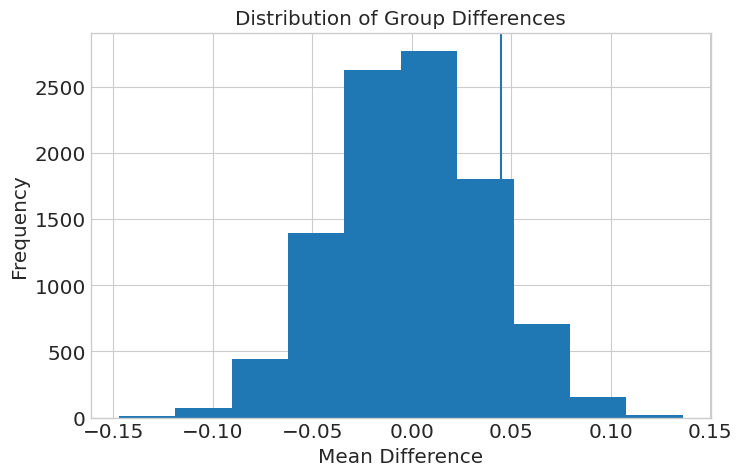

In [24]:
print("----------------------------------------------------")
print('\033[1m'+"Binomial test results:\n"+"\033[0;0m")
print("Binomial test for difference in proportion:\n")
print("P-value:",z_test_p_value)
print("\n")

print("Binomial confidence interval:\n")
print("Group 1 (yellow):",binomial_confidence_interval[0])
print("Group 2 (pink):",binomial_confidence_interval[1])
print("----------------------------------------------------")
print('\033[1m'+"Difference in means results:\n"+"\033[0;0m")
print("Effect size:",power_analysis.get_cohend_effectsize(group_1_means,
                                                         group_2_means))
print("\n")
print("T-test:\n")
responder_utils.t_test(group_1_means,
                      group_2_means,
                      0.05,
                      display=True)
print("Mann whitney test: ",stats.mannwhitneyu(group_1_means,group_2_means))
responder_utils.randomization_test(group_1_means, group_2_means, 
                   10000, 0.05,False)

#### Weekly confidence interval plot

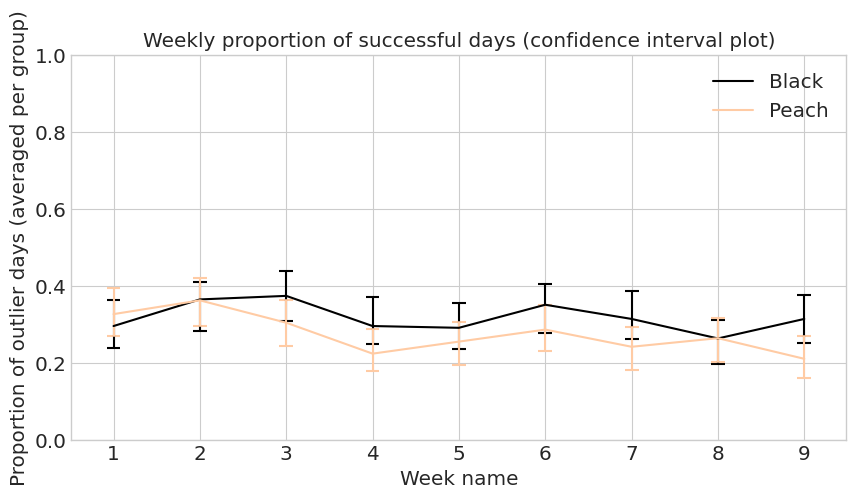

In [25]:
responder_utils.weekly_confidence_interval_plot(daily_success_matrix,
                                    weekly_success_matrix,
                                    group_1_names, group_2_names,
                                    response_direction,
                                    success_percent,
                                    significance_level,
                                    no_of_weeks,
                                    group_1_color, group_2_color,
                                    group_one_name, group_two_name)

### Active 900

#### Parameters

In [26]:
# Parameters
input_feature='active_900'
response_direction='increase'
success_percent=10
no_of_weeks=12
no_of_days=no_of_weeks*7
significance_level=0.05
study_day='NORMALIZED_QUALIFYING_STUDY_DAY_NEW'
group_1_color='black'
group_2_color='#FFCBA4'
group_one_name='Black'
group_two_name='Peach'

group_1_names=new_aging_df[new_aging_df['study_group']==\
                                    'Black']['external_patient_id'].unique()
group_2_names=new_aging_df[new_aging_df['study_group']==\
                                    'Peach']['external_patient_id'].unique()

#### Analysis

In [27]:
meta_columns=['external_patient_id', study_day,
              'study_group']
responder_analysis=ResponderAnalysis(feature_col=input_feature, 
                                     direction=response_direction, 
                                     success_percent=success_percent)

response_from_baseline=[]
for patient_name in new_aging_df['external_patient_id'].unique():
    features_tinker=meta_columns+[input_feature]
    sample_patient=new_aging_df[new_aging_df\
                                          ['external_patient_id']==patient_name]\
                                                        [features_tinker]\
                                                        .reset_index()\
                                                        .drop(['index'],axis=1)
    sample_patient.index=sample_patient[study_day]
    sample_patient = sample_patient.sort_index()
    # Baseline period
    baseline_period=sample_patient[(sample_patient[study_day]<0) &
                                  (sample_patient[study_day]>=-28)]
    # Treatment period
    treatment_period=sample_patient[sample_patient[study_day]>=0]
    # Baseline mean
    baseline_mean=baseline_period[input_feature].mean()
    # percentage change
    treatment_period=responder_analysis.percentage_change(treatment_period, 
                                                          baseline_mean)
    response_from_baseline.append(treatment_period[['external_patient_id',
                                                    study_day,\
                                                    '% '+response_direction+' '+input_feature]])

# Creating response matrix and daily/weekly success df
response_from_baseline_df=pd.concat(response_from_baseline)

daily_success_matrix = response_from_baseline_df.pivot(index=study_day,
                                        columns='external_patient_id',
                                        values='% '+response_direction+' '+input_feature)
weekly_success_matrix=responder_analysis.predict(daily_success_matrix)

# Binomial test
group_1_flat=pd.DataFrame(daily_success_matrix[group_1_names]\
                                 .iloc[:no_of_days]\
                                 .values.flatten()).dropna()
group_2_flat=pd.DataFrame(daily_success_matrix[group_2_names]\
                                 .iloc[:no_of_days]\
                                 .values.flatten()).dropna()
if response_direction == 'increase':
    print("increase")
    success_count_group_1 = \
        group_1_flat[group_1_flat[0] > success_percent].shape[0]
    total_number_of_trial_group_1 = group_1_flat.shape[0]

    success_count_group_2 = \
        group_2_flat[group_2_flat[0] > success_percent].shape[0]
    total_number_of_trial_group_2 = group_2_flat.shape[0]
elif response_direction == 'decrease':
    print("decrease")
    success_count_group_1 = \
        group_1_flat[group_1_flat[0] < -success_percent].shape[0]
    total_number_of_trial_group_1 = group_1_flat.shape[0]

    success_count_group_2 = \
        group_2_flat[group_2_flat[0] < -success_percent].shape[0]
    total_number_of_trial_group_2 = group_2_flat.shape[0]

increase


#### Test calculations

In [28]:
z_test_p_value=responder_utils.z_test(success_count_group_1/total_number_of_trial_group_1,\
                      success_count_group_2/total_number_of_trial_group_2,\
                      total_number_of_trial_group_1,\
                      total_number_of_trial_group_2)

# Binomial test
binomial_confidence_interval=responder_utils.binomial_confidence_interval(daily_success_matrix,
                                             group_1_names,
                                             group_2_names,
                                             no_of_days,
                                             response_direction,
                                             success_percent,
                                             significance_level)

# Difference of mean tests
group_1_means, group_2_means=responder_utils.proportion_per_patient(response_from_baseline_df,
                           '% '+response_direction+' '+input_feature,
                           response_direction,
                           success_percent,
                           study_day,
                           group_1_names,
                           group_2_names,
                           no_of_days)

#### Test results

----------------------------------------------------
Binomial test results:

Binomial test for difference in proportion:

P-value: 0.17726478279801505


Binomial confidence interval:

Group 1 (yellow): (0.32137231331566257, 0.35892204482006923)
Group 2 (pink): (0.30368579420067987, 0.34043658905213814)
----------------------------------------------------
Difference in means results:

Effect size: 0.10596545048839427


T-test:

                       T-test Assumptions                      
                                          Success/Fails P-value
---------------------------------------------------------------
1) Test for equality of variance (levene)       Success  0.4335
2) Test for normality (shapiro)                 Success        
 a) Group 1                                              0.8389
 b) Group 2                                              0.1039
---------------------------------------------------------------
Levene test
The Levene test tests the null hypothesis tha

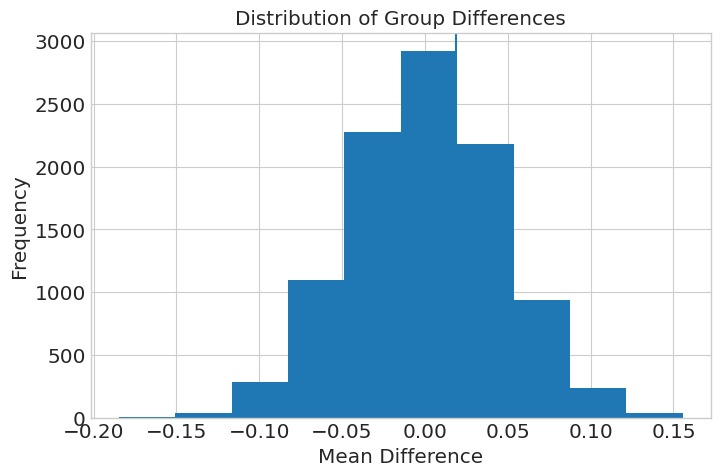

In [29]:
print("----------------------------------------------------")
print('\033[1m'+"Binomial test results:\n"+"\033[0;0m")
print("Binomial test for difference in proportion:\n")
print("P-value:",z_test_p_value)
print("\n")

print("Binomial confidence interval:\n")
print("Group 1 (yellow):",binomial_confidence_interval[0])
print("Group 2 (pink):",binomial_confidence_interval[1])
print("----------------------------------------------------")
print('\033[1m'+"Difference in means results:\n"+"\033[0;0m")
print("Effect size:",power_analysis.get_cohend_effectsize(group_1_means,
                                                         group_2_means))
print("\n")
print("T-test:\n")
responder_utils.t_test(group_1_means,
                      group_2_means,
                      0.05,
                      display=True)
print("Mann whitney test: ",stats.mannwhitneyu(group_1_means,group_2_means))
responder_utils.randomization_test(group_1_means, group_2_means, 
                   10000, 0.05,False)

#### Weekly confidence interval plot

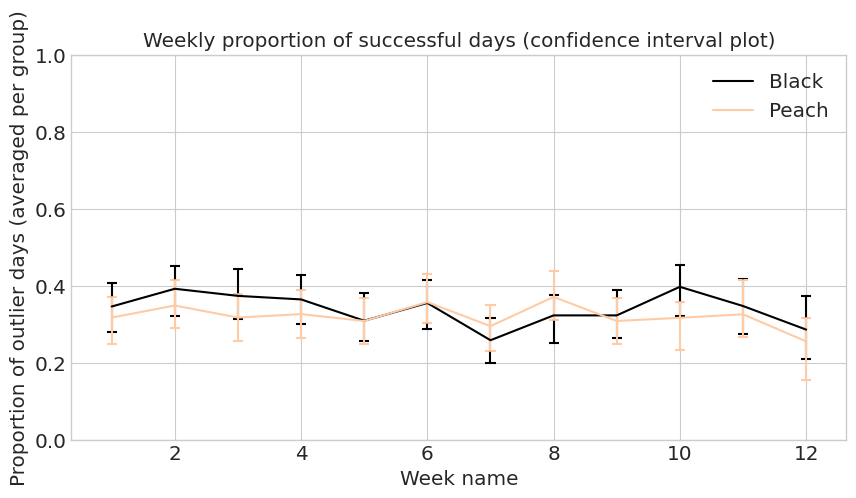

In [30]:
responder_utils.weekly_confidence_interval_plot(daily_success_matrix,
                                    weekly_success_matrix,
                                    group_1_names, group_2_names,
                                    response_direction,
                                    success_percent,
                                    significance_level,
                                    no_of_weeks,
                                    group_1_color, group_2_color,
                                    group_one_name, group_two_name)

### Resting_CE_6pm_12am

#### Parameters

In [31]:
# Parameters
input_feature='VAR_CE_1_Q4_2'
response_direction='decrease'
success_percent=10
no_of_weeks=12
no_of_days=no_of_weeks*7
significance_level=0.05
study_day='NORMALIZED_QUALIFYING_STUDY_DAY_NEW'
group_1_color='black'
group_2_color='#FFCBA4'
group_one_name='Black'
group_two_name='Peach'

group_1_names=new_aging_df[new_aging_df['study_group']==\
                                    'Black']['external_patient_id'].unique()
group_2_names=new_aging_df[new_aging_df['study_group']==\
                                    'Peach']['external_patient_id'].unique()

#### Analysis

In [32]:
meta_columns=['external_patient_id', study_day,
              'study_group']
responder_analysis=ResponderAnalysis(feature_col=input_feature, 
                                     direction=response_direction, 
                                     success_percent=success_percent)

response_from_baseline=[]
for patient_name in new_aging_df['external_patient_id'].unique():
    features_tinker=meta_columns+[input_feature]
    sample_patient=new_aging_df[new_aging_df\
                                          ['external_patient_id']==patient_name]\
                                                        [features_tinker]\
                                                        .reset_index()\
                                                        .drop(['index'],axis=1)
    sample_patient.index=sample_patient[study_day]
    sample_patient = sample_patient.sort_index()
    # Baseline period
    baseline_period=sample_patient[(sample_patient[study_day]<0) &
                                  (sample_patient[study_day]>=-28)]
    # Treatment period
    treatment_period=sample_patient[sample_patient[study_day]>=0]
    # Baseline mean
    baseline_mean=baseline_period[input_feature].mean()
    # percentage change
    treatment_period=responder_analysis.percentage_change(treatment_period, 
                                                          baseline_mean)
    response_from_baseline.append(treatment_period[['external_patient_id',
                                                    study_day,\
                                                    '% '+response_direction+' '+input_feature]])

# Creating response matrix and daily/weekly success df
response_from_baseline_df=pd.concat(response_from_baseline)

daily_success_matrix = response_from_baseline_df.pivot(index=study_day,
                                        columns='external_patient_id',
                                        values='% '+response_direction+' '+input_feature)
weekly_success_matrix=responder_analysis.predict(daily_success_matrix)

# Binomial test
group_1_flat=pd.DataFrame(daily_success_matrix[group_1_names]\
                                 .iloc[:no_of_days]\
                                 .values.flatten()).dropna()
group_2_flat=pd.DataFrame(daily_success_matrix[group_2_names]\
                                 .iloc[:no_of_days]\
                                 .values.flatten()).dropna()
if response_direction == 'increase':
    print('increase')
    success_count_group_1 = \
        group_1_flat[group_1_flat[0] > success_percent].shape[0]
    total_number_of_trial_group_1 = group_1_flat.shape[0]

    success_count_group_2 = \
        group_2_flat[group_2_flat[0] > success_percent].shape[0]
    total_number_of_trial_group_2 = group_2_flat.shape[0]
elif response_direction == 'decrease':
    print('decrease')
    success_count_group_1 = \
        group_1_flat[group_1_flat[0] < -success_percent].shape[0]
    total_number_of_trial_group_1 = group_1_flat.shape[0]

    success_count_group_2 = \
        group_2_flat[group_2_flat[0] < -success_percent].shape[0]
    total_number_of_trial_group_2 = group_2_flat.shape[0]

decrease


#### Test calculations

In [33]:
z_test_p_value=responder_utils.z_test(success_count_group_1/total_number_of_trial_group_1,\
                      success_count_group_2/total_number_of_trial_group_2,\
                      total_number_of_trial_group_1,\
                      total_number_of_trial_group_2)

# Binomial test
binomial_confidence_interval=responder_utils.binomial_confidence_interval(daily_success_matrix,
                                             group_1_names,
                                             group_2_names,
                                             no_of_days,
                                             response_direction,
                                             success_percent,
                                             significance_level)

# Difference of mean tests
group_1_means, group_2_means=responder_utils.proportion_per_patient(response_from_baseline_df,
                           '% '+response_direction+' '+input_feature,
                           response_direction,
                           success_percent,
                           study_day,
                           group_1_names,
                           group_2_names,
                           no_of_days)

#### Test results

----------------------------------------------------
Binomial test results:

Binomial test for difference in proportion:

P-value: 1.4669401658872499e-06


Binomial confidence interval:

Group 1 (yellow): (0.40599863154902543, 0.4451869776087833)
Group 2 (pink): (0.47430012535946586, 0.5136225799545437)
----------------------------------------------------
Difference in means results:

Effect size: -0.35813702925380203


T-test:

                       T-test Assumptions                      
                                          Success/Fails P-value
---------------------------------------------------------------
1) Test for equality of variance (levene)       Success  0.4127
2) Test for normality (shapiro)                   Fails        
 a) Group 1                                              0.9029
 b) Group 2                                              0.0383
---------------------------------------------------------------
Levene test
The Levene test tests the null hypothesis t

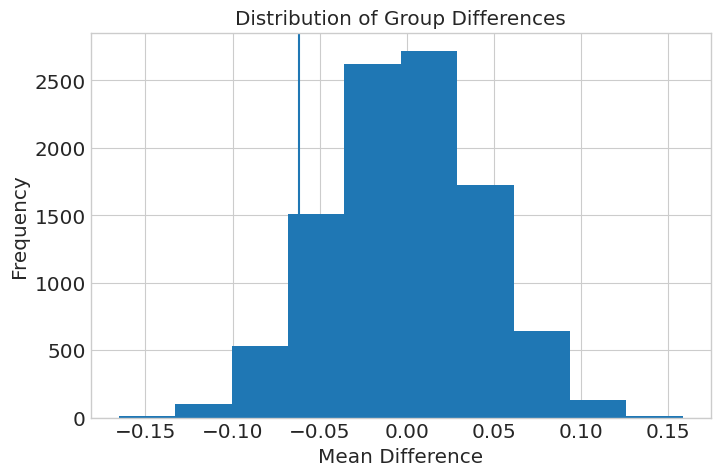

In [34]:
print("----------------------------------------------------")
print('\033[1m'+"Binomial test results:\n"+"\033[0;0m")
print("Binomial test for difference in proportion:\n")
print("P-value:",z_test_p_value)
print("\n")

print("Binomial confidence interval:\n")
print("Group 1 (yellow):",binomial_confidence_interval[0])
print("Group 2 (pink):",binomial_confidence_interval[1])
print("----------------------------------------------------")
print('\033[1m'+"Difference in means results:\n"+"\033[0;0m")
print("Effect size:",power_analysis.get_cohend_effectsize(group_1_means,
                                                         group_2_means))
print("\n")
print("T-test:\n")
responder_utils.t_test(group_1_means,
                      group_2_means,
                      0.05,
                      display=True)
print("Mann whitney test: ",stats.mannwhitneyu(group_1_means,group_2_means))
responder_utils.randomization_test(group_1_means, group_2_means, 
                   10000, 0.05,False)

#### Weekly confidence interval plot

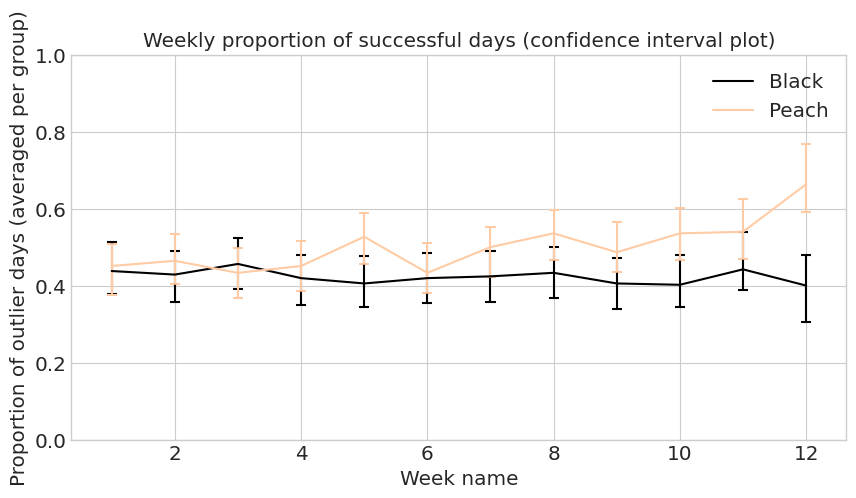

In [35]:
responder_utils.weekly_confidence_interval_plot(daily_success_matrix,
                                    weekly_success_matrix,
                                    group_1_names, group_2_names,
                                    response_direction,
                                    success_percent,
                                    significance_level,
                                    no_of_weeks,
                                    group_1_color, group_2_color,
                                    group_one_name, group_two_name)

### Running_ACE_6pm_12am

#### Parameters

In [36]:
# Parameters
input_feature='VAR_ACE_3_Q4_2'
response_direction='increase'
success_percent=10
no_of_weeks=12
no_of_days=no_of_weeks*7
significance_level=0.05
study_day='NORMALIZED_QUALIFYING_STUDY_DAY_NEW'
group_1_color='black'
group_2_color='#FFCBA4'
group_one_name='Black'
group_two_name='Peach'

group_1_names=new_aging_df[new_aging_df['study_group']==\
                                    'Black']['external_patient_id'].unique()
group_2_names=new_aging_df[new_aging_df['study_group']==\
                                    'Peach']['external_patient_id'].unique()

#### Analysis

In [37]:
meta_columns=['external_patient_id', study_day,
              'study_group']
responder_analysis=ResponderAnalysis(feature_col=input_feature, 
                                     direction=response_direction, 
                                     success_percent=success_percent)

response_from_baseline=[]
for patient_name in new_aging_df['external_patient_id'].unique():
    features_tinker=meta_columns+[input_feature]
    sample_patient=new_aging_df[new_aging_df\
                                          ['external_patient_id']==patient_name]\
                                                        [features_tinker]\
                                                        .reset_index()\
                                                        .drop(['index'],axis=1)
    sample_patient.index=sample_patient[study_day]
    sample_patient = sample_patient.sort_index()
    # Baseline period
    baseline_period=sample_patient[(sample_patient[study_day]<0) &
                                  (sample_patient[study_day]>=-28)]
    # Treatment period
    treatment_period=sample_patient[sample_patient[study_day]>=0]
    # Baseline mean
    baseline_mean=baseline_period[input_feature].mean()
    # percentage change
    treatment_period=responder_analysis.percentage_change(treatment_period, 
                                                          baseline_mean)
    response_from_baseline.append(treatment_period[['external_patient_id',
                                                    study_day,\
                                                    '% '+response_direction+' '+input_feature]])

# Creating response matrix and daily/weekly success df
response_from_baseline_df=pd.concat(response_from_baseline)

daily_success_matrix = response_from_baseline_df.pivot(index=study_day,
                                        columns='external_patient_id',
                                        values='% '+response_direction+' '+input_feature)
weekly_success_matrix=responder_analysis.predict(daily_success_matrix)

# Binomial test
group_1_flat=pd.DataFrame(daily_success_matrix[group_1_names]\
                                 .iloc[:no_of_days]\
                                 .values.flatten()).dropna()
group_2_flat=pd.DataFrame(daily_success_matrix[group_2_names]\
                                 .iloc[:no_of_days]\
                                 .values.flatten()).dropna()
if response_direction == 'increase':
    print('increase')
    success_count_group_1 = \
        group_1_flat[group_1_flat[0] > success_percent].shape[0]
    total_number_of_trial_group_1 = group_1_flat.shape[0]

    success_count_group_2 = \
        group_2_flat[group_2_flat[0] > success_percent].shape[0]
    total_number_of_trial_group_2 = group_2_flat.shape[0]
elif response_direction == 'decrease':
    print('decrease')
    success_count_group_1 = \
        group_1_flat[group_1_flat[0] < -success_percent].shape[0]
    total_number_of_trial_group_1 = group_1_flat.shape[0]

    success_count_group_2 = \
        group_2_flat[group_2_flat[0] < -success_percent].shape[0]
    total_number_of_trial_group_2 = group_2_flat.shape[0]

increase


#### Test calculations

In [38]:
z_test_p_value=responder_utils.z_test(success_count_group_1/total_number_of_trial_group_1,\
                      success_count_group_2/total_number_of_trial_group_2,\
                      total_number_of_trial_group_1,\
                      total_number_of_trial_group_2)

# Binomial test
binomial_confidence_interval=responder_utils.binomial_confidence_interval(daily_success_matrix,
                                             group_1_names,
                                             group_2_names,
                                             no_of_days,
                                             response_direction,
                                             success_percent,
                                             significance_level)

# Difference of mean tests
group_1_means, group_2_means=responder_utils.proportion_per_patient(response_from_baseline_df,
                           '% '+response_direction+' '+input_feature,
                           response_direction,
                           success_percent,
                           study_day,
                           group_1_names,
                           group_2_names,
                           no_of_days)

#### Test results

----------------------------------------------------
Binomial test results:

Binomial test for difference in proportion:

P-value: 0.0026949189118963546


Binomial confidence interval:

Group 1 (yellow): (0.30363957293562205, 0.34067767972177776)
Group 2 (pink): (0.34381437647360363, 0.3816284576648827)
----------------------------------------------------
Difference in means results:

Effect size: -0.22556112119598423


T-test:

                       T-test Assumptions                      
                                          Success/Fails P-value
---------------------------------------------------------------
1) Test for equality of variance (levene)       Success  0.1981
2) Test for normality (shapiro)                 Success        
 a) Group 1                                              0.9795
 b) Group 2                                              0.0955
---------------------------------------------------------------
Levene test
The Levene test tests the null hypothesis t

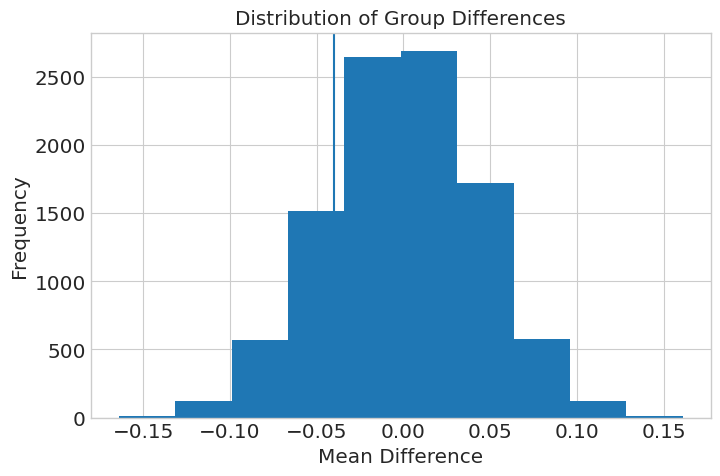

In [39]:
print("----------------------------------------------------")
print('\033[1m'+"Binomial test results:\n"+"\033[0;0m")
print("Binomial test for difference in proportion:\n")
print("P-value:",z_test_p_value)
print("\n")

print("Binomial confidence interval:\n")
print("Group 1 (yellow):",binomial_confidence_interval[0])
print("Group 2 (pink):",binomial_confidence_interval[1])
print("----------------------------------------------------")
print('\033[1m'+"Difference in means results:\n"+"\033[0;0m")
print("Effect size:",power_analysis.get_cohend_effectsize(group_1_means,
                                                         group_2_means))
print("\n")
print("T-test:\n")
responder_utils.t_test(group_1_means,
                      group_2_means,
                      0.05,
                      display=True)
print("Mann whitney test: ",stats.mannwhitneyu(group_1_means,group_2_means))
responder_utils.randomization_test(group_1_means, group_2_means, 
                   10000, 0.05,False)

#### Weekly confidence interval plot

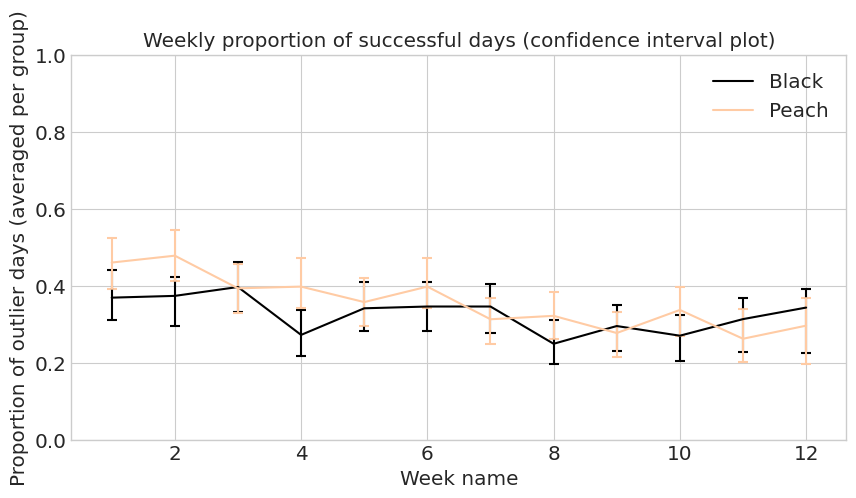

In [40]:
responder_utils.weekly_confidence_interval_plot(daily_success_matrix,
                                    weekly_success_matrix,
                                    group_1_names, group_2_names,
                                    response_direction,
                                    success_percent,
                                    significance_level,
                                    no_of_weeks,
                                    group_1_color, group_2_color,
                                    group_one_name, group_two_name)

### Sleeping_TD_6pm_12am

#### Parameters

In [41]:
# Parameters
input_feature='VAR_TD_12_Q4_2'
response_direction='decrease'
success_percent=10
no_of_weeks=12
no_of_days=no_of_weeks*7
significance_level=0.05
study_day='NORMALIZED_QUALIFYING_STUDY_DAY_NEW'
group_1_color='black'
group_2_color='#FFCBA4'
group_one_name='Black'
group_two_name='Peach'

group_1_names=new_aging_df[new_aging_df['study_group']==\
                                    'Black']['external_patient_id'].unique()
group_2_names=new_aging_df[new_aging_df['study_group']==\
                                    'Peach']['external_patient_id'].unique()

#### Analysis

In [42]:
meta_columns=['external_patient_id', study_day,
              'study_group']
responder_analysis=ResponderAnalysis(feature_col=input_feature, 
                                     direction=response_direction, 
                                     success_percent=success_percent)

response_from_baseline=[]
for patient_name in new_aging_df['external_patient_id'].unique():
    features_tinker=meta_columns+[input_feature]
    sample_patient=new_aging_df[new_aging_df\
                                          ['external_patient_id']==patient_name]\
                                                        [features_tinker]\
                                                        .reset_index()\
                                                        .drop(['index'],axis=1)
    sample_patient.index=sample_patient[study_day]
    sample_patient = sample_patient.sort_index()
    # Baseline period
    baseline_period=sample_patient[(sample_patient[study_day]<0) &
                                  (sample_patient[study_day]>=-28)]
    # Treatment period
    treatment_period=sample_patient[sample_patient[study_day]>=0]
    # Baseline mean
    baseline_mean=baseline_period[input_feature].mean()
    # percentage change
    treatment_period=responder_analysis.percentage_change(treatment_period, 
                                                          baseline_mean)
    response_from_baseline.append(treatment_period[['external_patient_id',
                                                    study_day,\
                                                    '% '+response_direction+' '+input_feature]])

# Creating response matrix and daily/weekly success df
response_from_baseline_df=pd.concat(response_from_baseline)

daily_success_matrix = response_from_baseline_df.pivot(index=study_day,
                                        columns='external_patient_id',
                                        values='% '+response_direction+' '+input_feature)
weekly_success_matrix=responder_analysis.predict(daily_success_matrix)

# Binomial test
group_1_flat=pd.DataFrame(daily_success_matrix[group_1_names]\
                                 .iloc[:no_of_days]\
                                 .values.flatten()).dropna()
group_2_flat=pd.DataFrame(daily_success_matrix[group_2_names]\
                                 .iloc[:no_of_days]\
                                 .values.flatten()).dropna()
if response_direction == 'increase':
    print('increase')
    success_count_group_1 = \
        group_1_flat[group_1_flat[0] > success_percent].shape[0]
    total_number_of_trial_group_1 = group_1_flat.shape[0]

    success_count_group_2 = \
        group_2_flat[group_2_flat[0] > success_percent].shape[0]
    total_number_of_trial_group_2 = group_2_flat.shape[0]
elif response_direction == 'decrease':
    print('decrease')
    success_count_group_1 = \
        group_1_flat[group_1_flat[0] < -success_percent].shape[0]
    total_number_of_trial_group_1 = group_1_flat.shape[0]

    success_count_group_2 = \
        group_2_flat[group_2_flat[0] < -success_percent].shape[0]
    total_number_of_trial_group_2 = group_2_flat.shape[0]

decrease


#### Test calculations

In [43]:
z_test_p_value=responder_utils.z_test(success_count_group_1/total_number_of_trial_group_1,\
                      success_count_group_2/total_number_of_trial_group_2,\
                      total_number_of_trial_group_1,\
                      total_number_of_trial_group_2)

# Binomial test
binomial_confidence_interval=responder_utils.binomial_confidence_interval(daily_success_matrix,
                                             group_1_names,
                                             group_2_names,
                                             no_of_days,
                                             response_direction,
                                             success_percent,
                                             significance_level)

# Difference of mean tests
group_1_means, group_2_means=responder_utils.proportion_per_patient(response_from_baseline_df,
                           '% '+response_direction+' '+input_feature,
                           response_direction,
                           success_percent,
                           study_day,
                           group_1_names,
                           group_2_names,
                           no_of_days)

#### Test results

----------------------------------------------------
Binomial test results:

Binomial test for difference in proportion:

P-value: 0.00010822444157206708


Binomial confidence interval:

Group 1 (yellow): (0.2931758208991658, 0.3298822330664924)
Group 2 (pink): (0.24438941317020257, 0.2789600232227121)
----------------------------------------------------
Difference in means results:

Effect size: 0.2951639137533371


T-test:

                       T-test Assumptions                      
                                          Success/Fails P-value
---------------------------------------------------------------
1) Test for equality of variance (levene)       Success  0.2831
2) Test for normality (shapiro)                   Fails        
 a) Group 1                                              0.0498
 b) Group 2                                              0.0510
---------------------------------------------------------------
Levene test
The Levene test tests the null hypothesis that

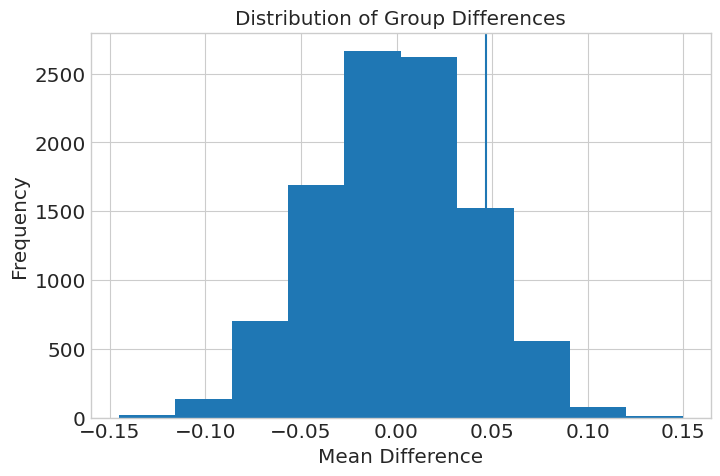

In [44]:
print("----------------------------------------------------")
print('\033[1m'+"Binomial test results:\n"+"\033[0;0m")
print("Binomial test for difference in proportion:\n")
print("P-value:",z_test_p_value)
print("\n")

print("Binomial confidence interval:\n")
print("Group 1 (yellow):",binomial_confidence_interval[0])
print("Group 2 (pink):",binomial_confidence_interval[1])
print("----------------------------------------------------")
print('\033[1m'+"Difference in means results:\n"+"\033[0;0m")
print("Effect size:",power_analysis.get_cohend_effectsize(group_1_means,
                                                         group_2_means))
print("\n")
print("T-test:\n")
responder_utils.t_test(group_1_means,
                      group_2_means,
                      0.05,
                      display=True)
print("Mann whitney test: ",stats.mannwhitneyu(group_1_means,group_2_means))
responder_utils.randomization_test(group_1_means, group_2_means, 
                   10000, 0.05,False)

#### Weekly confidence interval plot

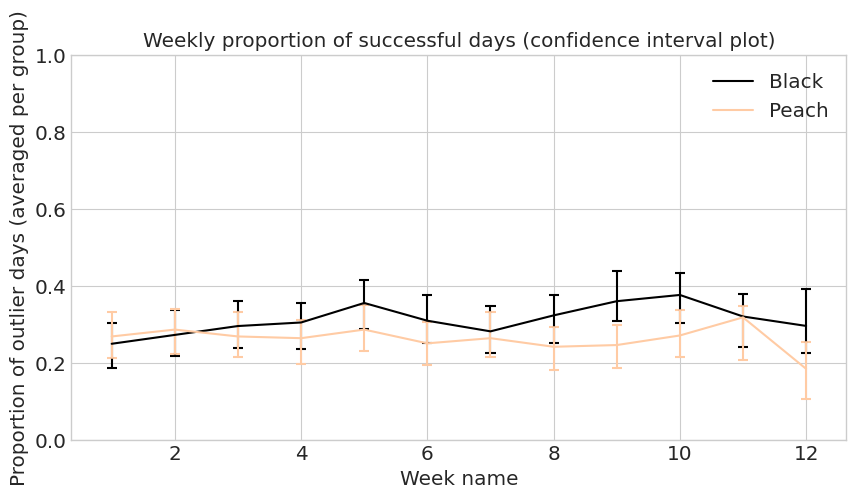

In [45]:
responder_utils.weekly_confidence_interval_plot(daily_success_matrix,
                                    weekly_success_matrix,
                                    group_1_names, group_2_names,
                                    response_direction,
                                    success_percent,
                                    significance_level,
                                    no_of_weeks,
                                    group_1_color, group_2_color,
                                    group_one_name, group_two_name)